In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


In [2]:
# Shared Generator Layers
class SharedGeneratorLayers(nn.Module):
    def __init__(self):
        super(SharedGeneratorLayers, self).__init__()
        self.main = nn.Sequential(
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.main(x)
        return x

In [3]:
# Generator
class Generator(nn.Module):
    def __init__(self, latent_dim, shared_layers):
        super(Generator, self).__init__()
        self.fc = nn.Linear(latent_dim, 256)
        self.shared_layers = shared_layers

    def forward(self, z):
        x = self.fc(z)
        x = self.shared_layers(x)
        return x

In [4]:
# Shared Discriminator and Classifier Layers
class SharedDiscriminatorClassifierLayers(nn.Module):
    def __init__(self):
        super(SharedDiscriminatorClassifierLayers, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(784, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3)
        )

    def forward(self, x):
        x = self.main(x)
        return x

In [5]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self, shared_layers):
        super(Discriminator, self).__init__()
        self.shared_layers = shared_layers
        self.fc = nn.Linear(256, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.shared_layers(x)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

In [6]:
# Classifier
class Classifier(nn.Module):
    def __init__(self, shared_layers, num_generators):
        super(Classifier, self).__init__()
        self.shared_layers = shared_layers
        self.fc = nn.Linear(256, num_generators)

    def forward(self, x):
        x = self.shared_layers(x)
        x = self.fc(x)
        return x

In [7]:
import matplotlib.pyplot as plt


def generate_and_plot(generators, latent_dim, device):
    num_generators = len(generators)  # Get the number of generators
    images_per_generator = 5  # Set how many images to display per generator
    fig, axes = plt.subplots(num_generators, images_per_generator, figsize=(images_per_generator * 2, num_generators * 2))
    
    # Loop through each generator and generate samples
    for gen_idx, generator in enumerate(generators):
        generator.eval()  # Set the generator to evaluation mode
        with torch.no_grad():
            # Generate latent vectors for the generator
            z = torch.randn(images_per_generator, latent_dim, device=device)
            generated_images = generator(z).cpu().numpy()  # Generate images and move them to CPU for plotting

        # Visualize the images generated by this generator
        for img_idx in range(images_per_generator):
            ax = axes[gen_idx, img_idx]
            
            # If the generated images are flattened (like MNIST), reshape them
            image = generated_images[img_idx]
            
            if image.shape == (784,):  # For MNIST, where images are flattened
                image = image.reshape(28, 28)  # Reshape to 28x28 for grayscale images
            
            # If working with RGB, ensure image has the shape (height, width, channels)
            elif len(image.shape) == 1 and image.size == 784 * 3:  # Example for flattened RGB
                image = image.reshape(28, 28, 3)  # Reshape to (28, 28, 3) for RGB
            
            ax.imshow(image, cmap='gray' if image.ndim == 2 else None)  # Use 'gray' cmap for grayscale
            ax.set_title(f"Generator {gen_idx + 1}")  # Label the image with the generator index
            ax.axis('off')  # Turn off the axis

    plt.tight_layout()
    plt.show()


In [8]:
def train_mgans(generators, discriminator, classifier, train_loader, latent_dim, num_epochs, beta, device, visualize_frequency):
    criterion_bce = nn.BCELoss()
    criterion_ce = nn.CrossEntropyLoss()

    # Collect generator parameters
    gen_params = []
    for gen in generators:
        gen_params += list(gen.fc.parameters())
    gen_params += list(generators[0].shared_layers.parameters())  # Shared layers are the same

    optimizer_G = optim.Adam(gen_params, lr=0.0002, betas=(0.5, 0.999))

    # Discriminator and Classifier params
    dc_params = list(discriminator.shared_layers.parameters()) + \
                list(discriminator.fc.parameters()) + \
                list(classifier.fc.parameters())
    optimizer_DC = optim.Adam(dc_params, lr=0.0002, betas=(0.5, 0.999))

    # History to track losses
    history = {'d_loss': [], 'g_loss': [], 'c_loss': []}

    for epoch in range(num_epochs):
        for batch_idx, (real_images, _) in enumerate(train_loader):
            # Prepare real images
            real_images = real_images.view(-1, 28 * 28).to(device)
            batch_size_real = real_images.size(0)

            # Labels for real images
            real_labels = torch.ones(batch_size_real, 1).to(device)

            # Zero gradients for discriminator and classifier
            optimizer_DC.zero_grad()

            # Discriminator loss on real images
            outputs = discriminator(real_images)
            d_loss_real = criterion_bce(outputs, real_labels)

            # Prepare fake images and labels
            fake_images_list = []
            fake_labels_list = []
            batch_size_fake = batch_size_real  # For each generator

            for idx, gen in enumerate(generators):
                z = torch.randn(batch_size_fake, latent_dim).to(device)
                fake_images = gen(z)
                fake_images_list.append(fake_images)
                fake_labels_list.append(torch.full((batch_size_fake,), idx, dtype=torch.long))

            # Concatenate fake images and labels
            fake_images = torch.cat(fake_images_list, dim=0)
            fake_labels = torch.cat(fake_labels_list, dim=0).to(device)

            # Labels for fake images for discriminator
            fake_labels_dis = torch.zeros(fake_images.size(0), 1).to(device)

            # Discriminator loss on fake images
            outputs = discriminator(fake_images.detach())
            d_loss_fake = criterion_bce(outputs, fake_labels_dis)

            # Total discriminator loss
            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            optimizer_DC.step()

            # Train Classifier
            optimizer_DC.zero_grad()
            outputs = classifier(fake_images.detach())
            c_loss = beta * criterion_ce(outputs, fake_labels)
            c_loss.backward()
            optimizer_DC.step()

            # Train Generators
            optimizer_G.zero_grad()

            # Generator adversarial loss
            outputs = discriminator(fake_images)
            real_labels_gen = torch.ones(fake_images.size(0), 1).to(device)
            g_loss_adv = criterion_bce(outputs, real_labels_gen)

            # Generator classification loss
            outputs = classifier(fake_images)
            g_loss_cls = criterion_ce(outputs, fake_labels)

            # Total generator loss
            g_loss = g_loss_adv - beta * g_loss_cls
            g_loss.backward()
            optimizer_G.step()

            if batch_idx % 100 == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}], '
                      f'D Loss: {d_loss.item():.4f}, C Loss: {c_loss.item():.4f}, G Loss: {g_loss.item():.4f}')

            # Save losses
            history['d_loss'].append(d_loss.item())
            history['g_loss'].append(g_loss.item())
            history['c_loss'].append(c_loss.item())

        # Visualize every 3 epochs
        if (epoch + 1) % visualize_frequency == 0:
            print(f'Generating samples at epoch {epoch + 1}')
            generate_and_plot(generators, latent_dim, device)

    return history

In [9]:
# Hyperparameters
batch_size = 64
num_epochs = 100
learning_rate = 0.0002
latent_dim = 100
num_generators = 5
beta = 1.0  # Diversity hyperparameter
visualize_frequency = 5

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [10]:
# MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

train_dataset = datasets.MNIST(root='data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size * num_generators, shuffle=True)


In [11]:
def plot_training_history(history, num_epochs):
    # Extract losses from history
    d_loss = history['d_loss']  # Discriminator loss
    g_loss = history['g_loss']  # Generator loss
    c_loss = history['c_loss']  # Classifier loss

    # Plot Discriminator Loss
    plt.figure(figsize=(10, 6))
    plt.plot(d_loss, label='Discriminator Loss', color='blue')
    
    # Plot Generator Loss
    plt.plot(g_loss, label='Generator Loss', color='green')

    # Plot Classifier Loss
    plt.plot(c_loss, label='Classifier Loss', color='red')

    # Labels and Title
    plt.title(f'Loss Curves over {num_epochs} Epochs')
    plt.xlabel('Batch Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Show the plot
    plt.tight_layout()
    plt.show()

Epoch [1/100], Batch [0/188], D Loss: 1.3801, C Loss: 1.6110, G Loss: -0.9257
Epoch [1/100], Batch [100/188], D Loss: 1.5217, C Loss: 1.6108, G Loss: -0.8242
Epoch [2/100], Batch [0/188], D Loss: 1.1546, C Loss: 1.6102, G Loss: -0.8220
Epoch [2/100], Batch [100/188], D Loss: 1.3630, C Loss: 1.6123, G Loss: 0.4101
Epoch [3/100], Batch [0/188], D Loss: 1.3741, C Loss: 1.6095, G Loss: -0.6470
Epoch [3/100], Batch [100/188], D Loss: 1.0853, C Loss: 1.6108, G Loss: -0.4765
Epoch [4/100], Batch [0/188], D Loss: 1.0224, C Loss: 1.6083, G Loss: -0.5533
Epoch [4/100], Batch [100/188], D Loss: 1.0961, C Loss: 1.6099, G Loss: -0.7198
Epoch [5/100], Batch [0/188], D Loss: 1.0176, C Loss: 1.6101, G Loss: -0.8488
Epoch [5/100], Batch [100/188], D Loss: 1.0105, C Loss: 1.6119, G Loss: -0.3518
Generating samples at epoch 5


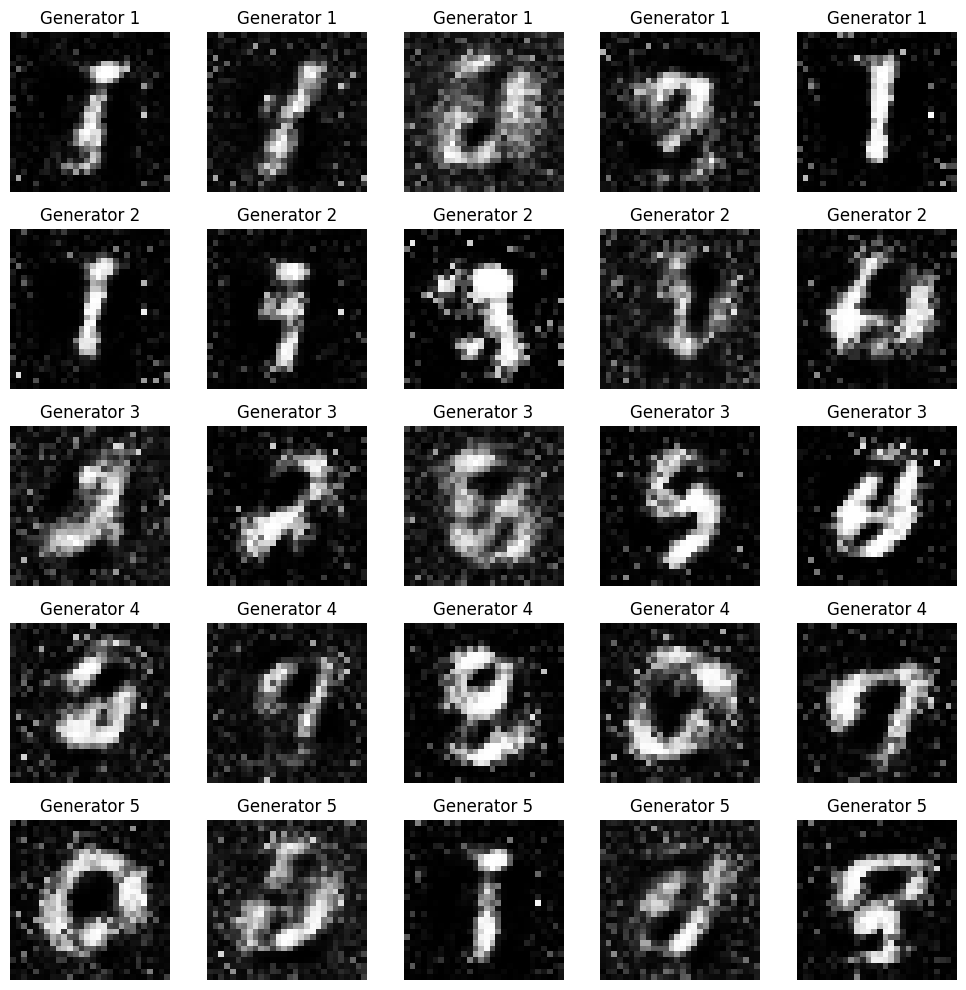

Epoch [6/100], Batch [0/188], D Loss: 1.4584, C Loss: 1.6104, G Loss: 0.4239
Epoch [6/100], Batch [100/188], D Loss: 1.2126, C Loss: 1.6092, G Loss: -0.7561
Epoch [7/100], Batch [0/188], D Loss: 1.0244, C Loss: 1.6097, G Loss: -0.4633
Epoch [7/100], Batch [100/188], D Loss: 1.1792, C Loss: 1.6087, G Loss: -0.3580
Epoch [8/100], Batch [0/188], D Loss: 1.1017, C Loss: 1.6098, G Loss: -0.5263
Epoch [8/100], Batch [100/188], D Loss: 1.1024, C Loss: 1.6074, G Loss: -0.4479
Epoch [9/100], Batch [0/188], D Loss: 1.1485, C Loss: 1.6073, G Loss: -0.6343
Epoch [9/100], Batch [100/188], D Loss: 1.2039, C Loss: 1.6092, G Loss: -0.5614
Epoch [10/100], Batch [0/188], D Loss: 1.2740, C Loss: 1.6092, G Loss: -0.8427
Epoch [10/100], Batch [100/188], D Loss: 1.2157, C Loss: 1.6103, G Loss: -0.8234
Generating samples at epoch 10


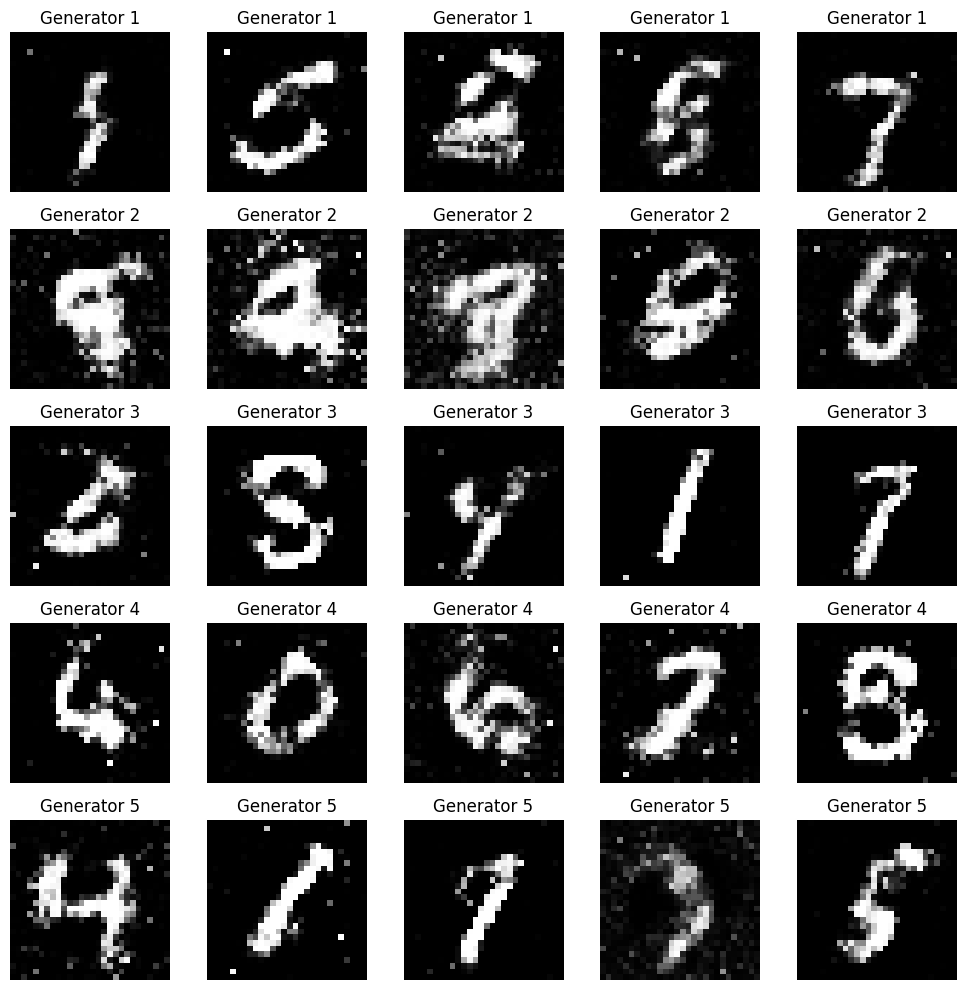

Epoch [11/100], Batch [0/188], D Loss: 1.1570, C Loss: 1.6102, G Loss: -0.6006
Epoch [11/100], Batch [100/188], D Loss: 1.1523, C Loss: 1.6105, G Loss: -0.3402
Epoch [12/100], Batch [0/188], D Loss: 1.1775, C Loss: 1.6098, G Loss: -0.6723
Epoch [12/100], Batch [100/188], D Loss: 1.2146, C Loss: 1.6102, G Loss: -0.5540
Epoch [13/100], Batch [0/188], D Loss: 1.1999, C Loss: 1.6091, G Loss: -0.8149
Epoch [13/100], Batch [100/188], D Loss: 1.2651, C Loss: 1.6101, G Loss: -0.8606
Epoch [14/100], Batch [0/188], D Loss: 1.3090, C Loss: 1.6090, G Loss: -0.3780
Epoch [14/100], Batch [100/188], D Loss: 1.2075, C Loss: 1.6103, G Loss: -0.8047
Epoch [15/100], Batch [0/188], D Loss: 1.2139, C Loss: 1.6103, G Loss: -0.6200
Epoch [15/100], Batch [100/188], D Loss: 1.2837, C Loss: 1.6122, G Loss: -0.7936
Generating samples at epoch 15


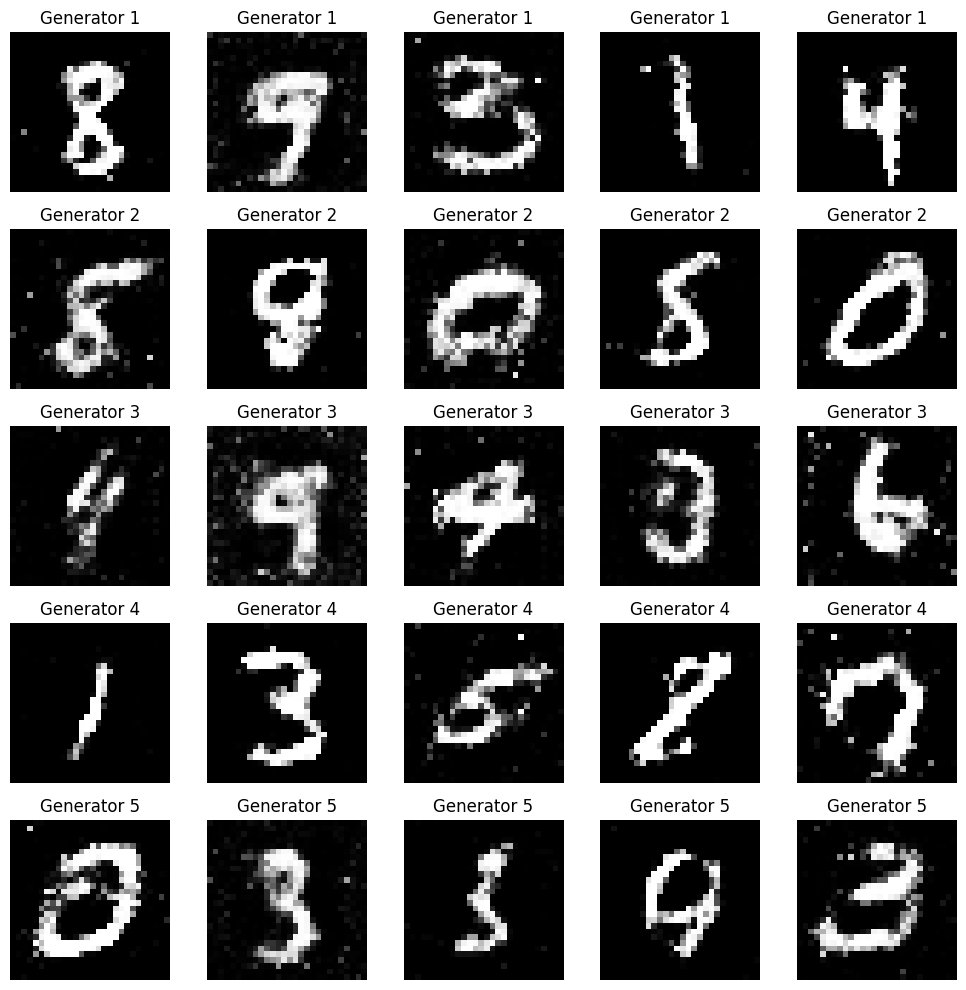

Epoch [16/100], Batch [0/188], D Loss: 1.3085, C Loss: 1.6097, G Loss: -0.4579
Epoch [16/100], Batch [100/188], D Loss: 1.2276, C Loss: 1.6101, G Loss: -0.6744
Epoch [17/100], Batch [0/188], D Loss: 1.2459, C Loss: 1.6096, G Loss: -0.7779
Epoch [17/100], Batch [100/188], D Loss: 1.2149, C Loss: 1.6109, G Loss: -0.7497
Epoch [18/100], Batch [0/188], D Loss: 1.2283, C Loss: 1.6097, G Loss: -0.7706
Epoch [18/100], Batch [100/188], D Loss: 1.2494, C Loss: 1.6109, G Loss: -0.9325
Epoch [19/100], Batch [0/188], D Loss: 1.2368, C Loss: 1.6092, G Loss: -0.8102
Epoch [19/100], Batch [100/188], D Loss: 1.2669, C Loss: 1.6079, G Loss: -0.4822
Epoch [20/100], Batch [0/188], D Loss: 1.2556, C Loss: 1.6095, G Loss: -0.6648
Epoch [20/100], Batch [100/188], D Loss: 1.2589, C Loss: 1.6095, G Loss: -0.7628
Generating samples at epoch 20


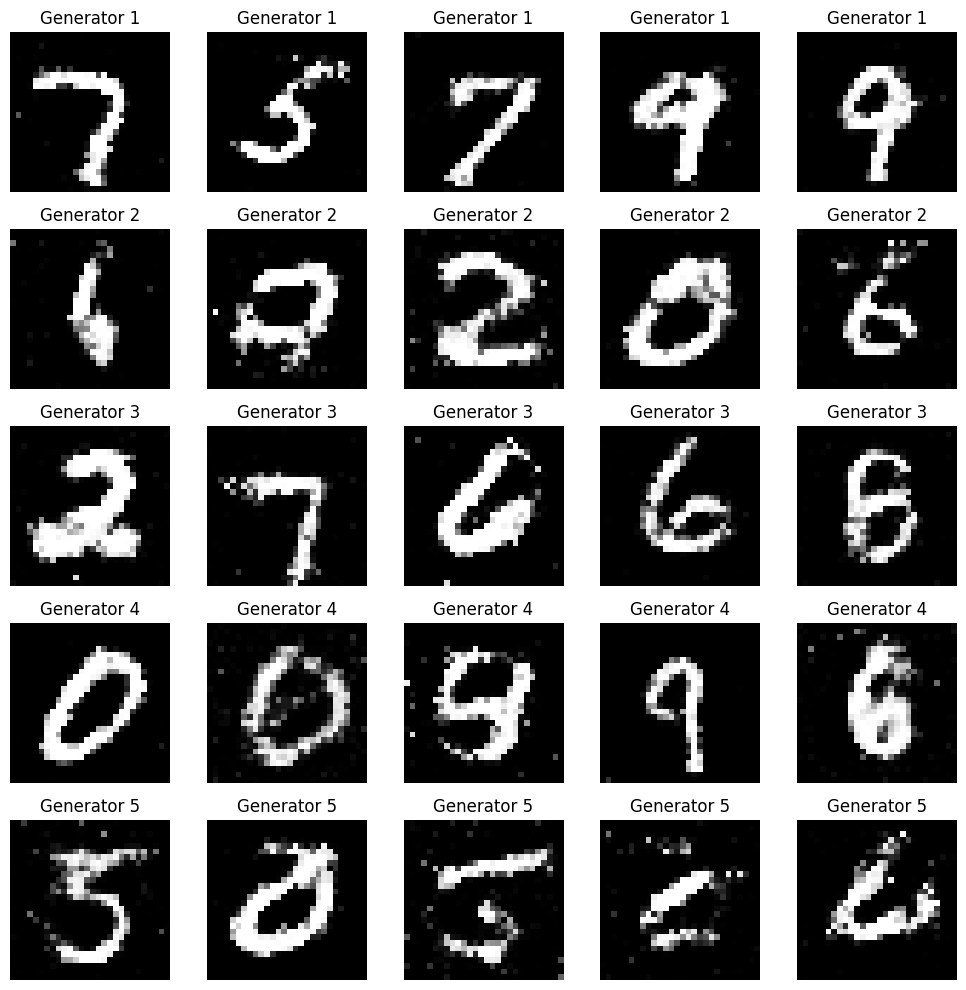

Epoch [21/100], Batch [0/188], D Loss: 1.3072, C Loss: 1.6105, G Loss: -0.5901
Epoch [21/100], Batch [100/188], D Loss: 1.3156, C Loss: 1.6086, G Loss: -0.4637
Epoch [22/100], Batch [0/188], D Loss: 1.3612, C Loss: 1.6103, G Loss: -0.5306
Epoch [22/100], Batch [100/188], D Loss: 1.3279, C Loss: 1.6091, G Loss: -0.6728
Epoch [23/100], Batch [0/188], D Loss: 1.3262, C Loss: 1.6095, G Loss: -0.6601
Epoch [23/100], Batch [100/188], D Loss: 1.3027, C Loss: 1.6099, G Loss: -0.6949
Epoch [24/100], Batch [0/188], D Loss: 1.3224, C Loss: 1.6092, G Loss: -0.6865
Epoch [24/100], Batch [100/188], D Loss: 1.3028, C Loss: 1.6094, G Loss: -0.9102
Epoch [25/100], Batch [0/188], D Loss: 1.3225, C Loss: 1.6095, G Loss: -0.7031
Epoch [25/100], Batch [100/188], D Loss: 1.2789, C Loss: 1.6110, G Loss: -0.7674
Generating samples at epoch 25


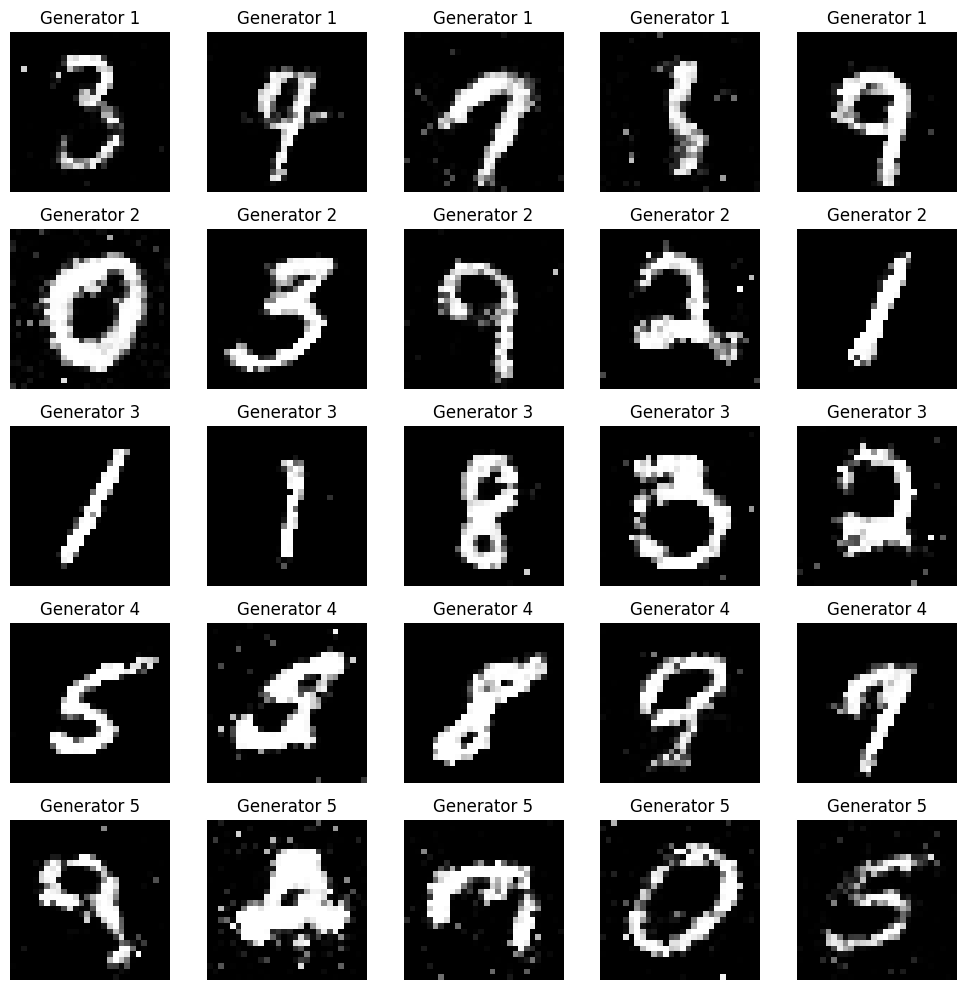

Epoch [26/100], Batch [0/188], D Loss: 1.3431, C Loss: 1.6086, G Loss: -0.4019
Epoch [26/100], Batch [100/188], D Loss: 1.2744, C Loss: 1.6097, G Loss: -0.7717
Epoch [27/100], Batch [0/188], D Loss: 1.3776, C Loss: 1.6100, G Loss: -0.6135
Epoch [27/100], Batch [100/188], D Loss: 1.3149, C Loss: 1.6109, G Loss: -0.6781
Epoch [28/100], Batch [0/188], D Loss: 1.2979, C Loss: 1.6097, G Loss: -0.7849
Epoch [28/100], Batch [100/188], D Loss: 1.3063, C Loss: 1.6086, G Loss: -0.8699
Epoch [29/100], Batch [0/188], D Loss: 1.3074, C Loss: 1.6085, G Loss: -0.8971
Epoch [29/100], Batch [100/188], D Loss: 1.3277, C Loss: 1.6093, G Loss: -0.8964
Epoch [30/100], Batch [0/188], D Loss: 1.3186, C Loss: 1.6102, G Loss: -0.8049
Epoch [30/100], Batch [100/188], D Loss: 1.2915, C Loss: 1.6088, G Loss: -0.8792
Generating samples at epoch 30


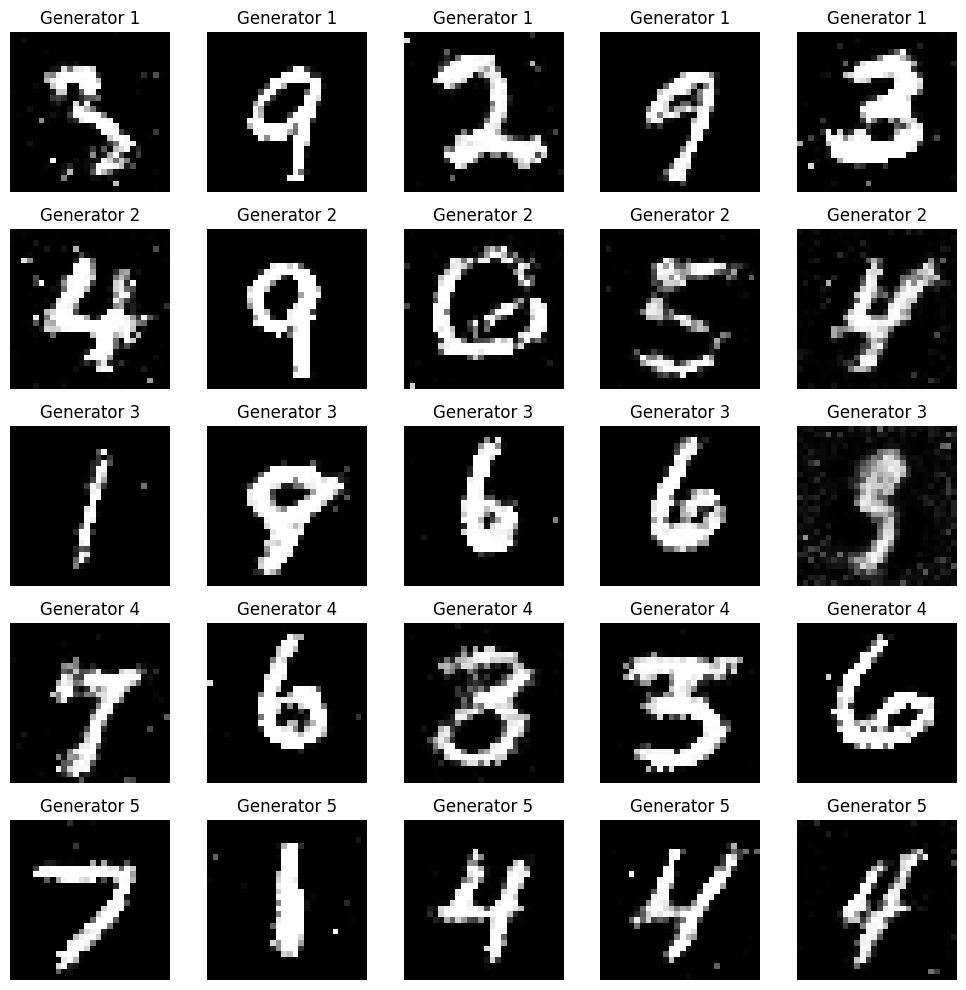

Epoch [31/100], Batch [0/188], D Loss: 1.3579, C Loss: 1.6096, G Loss: -0.4457
Epoch [31/100], Batch [100/188], D Loss: 1.3153, C Loss: 1.6096, G Loss: -0.7550
Epoch [32/100], Batch [0/188], D Loss: 1.3654, C Loss: 1.6116, G Loss: -1.0193
Epoch [32/100], Batch [100/188], D Loss: 1.3510, C Loss: 1.6093, G Loss: -0.9349
Epoch [33/100], Batch [0/188], D Loss: 1.3284, C Loss: 1.6102, G Loss: -0.6605
Epoch [33/100], Batch [100/188], D Loss: 1.3563, C Loss: 1.6097, G Loss: -0.9418
Epoch [34/100], Batch [0/188], D Loss: 1.3653, C Loss: 1.6097, G Loss: -0.4324
Epoch [34/100], Batch [100/188], D Loss: 1.3056, C Loss: 1.6102, G Loss: -0.8443
Epoch [35/100], Batch [0/188], D Loss: 1.3537, C Loss: 1.6083, G Loss: -0.5875
Epoch [35/100], Batch [100/188], D Loss: 1.3289, C Loss: 1.6097, G Loss: -0.7819
Generating samples at epoch 35


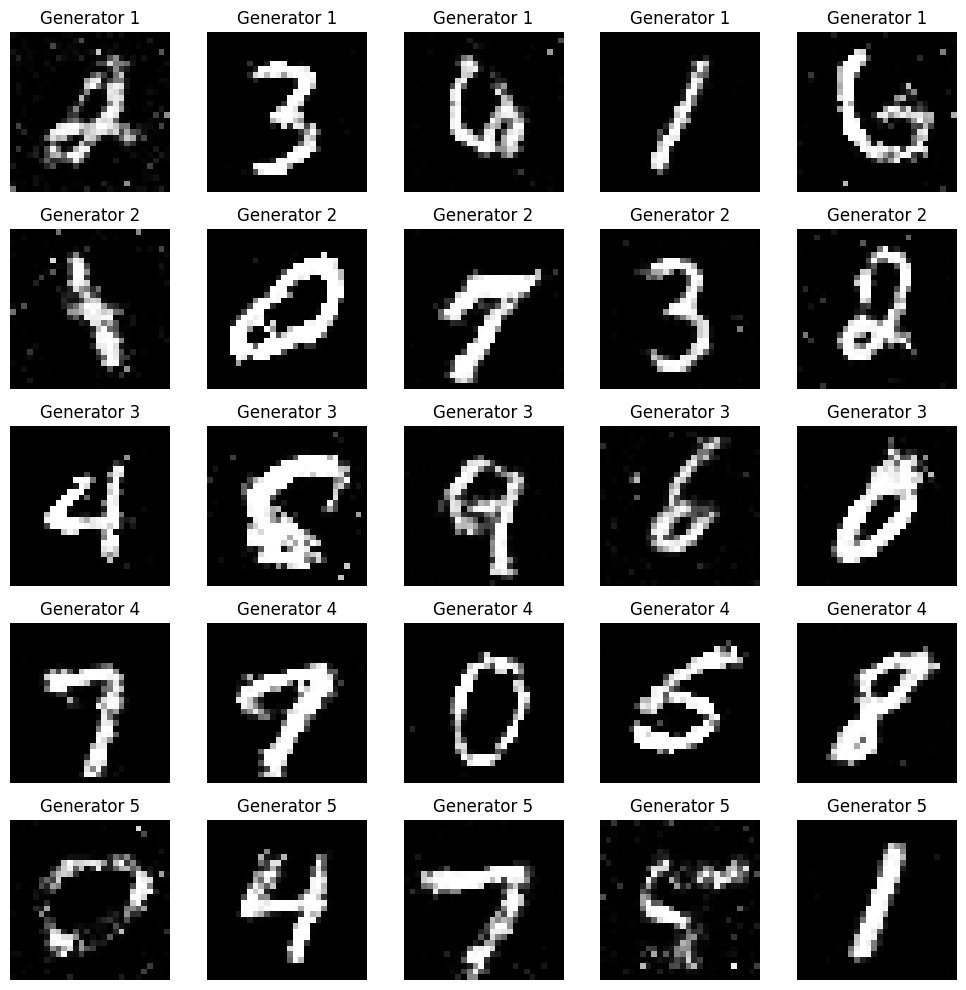

Epoch [36/100], Batch [0/188], D Loss: 1.3504, C Loss: 1.6095, G Loss: -0.7376
Epoch [36/100], Batch [100/188], D Loss: 1.3531, C Loss: 1.6102, G Loss: -0.9179
Epoch [37/100], Batch [0/188], D Loss: 1.3279, C Loss: 1.6093, G Loss: -0.8764
Epoch [37/100], Batch [100/188], D Loss: 1.3256, C Loss: 1.6093, G Loss: -0.7037
Epoch [38/100], Batch [0/188], D Loss: 1.3491, C Loss: 1.6092, G Loss: -0.7496
Epoch [38/100], Batch [100/188], D Loss: 1.3337, C Loss: 1.6088, G Loss: -0.8475
Epoch [39/100], Batch [0/188], D Loss: 1.3514, C Loss: 1.6089, G Loss: -0.7434
Epoch [39/100], Batch [100/188], D Loss: 1.3258, C Loss: 1.6086, G Loss: -0.8207
Epoch [40/100], Batch [0/188], D Loss: 1.3316, C Loss: 1.6102, G Loss: -0.8348
Epoch [40/100], Batch [100/188], D Loss: 1.3521, C Loss: 1.6098, G Loss: -0.8828
Generating samples at epoch 40


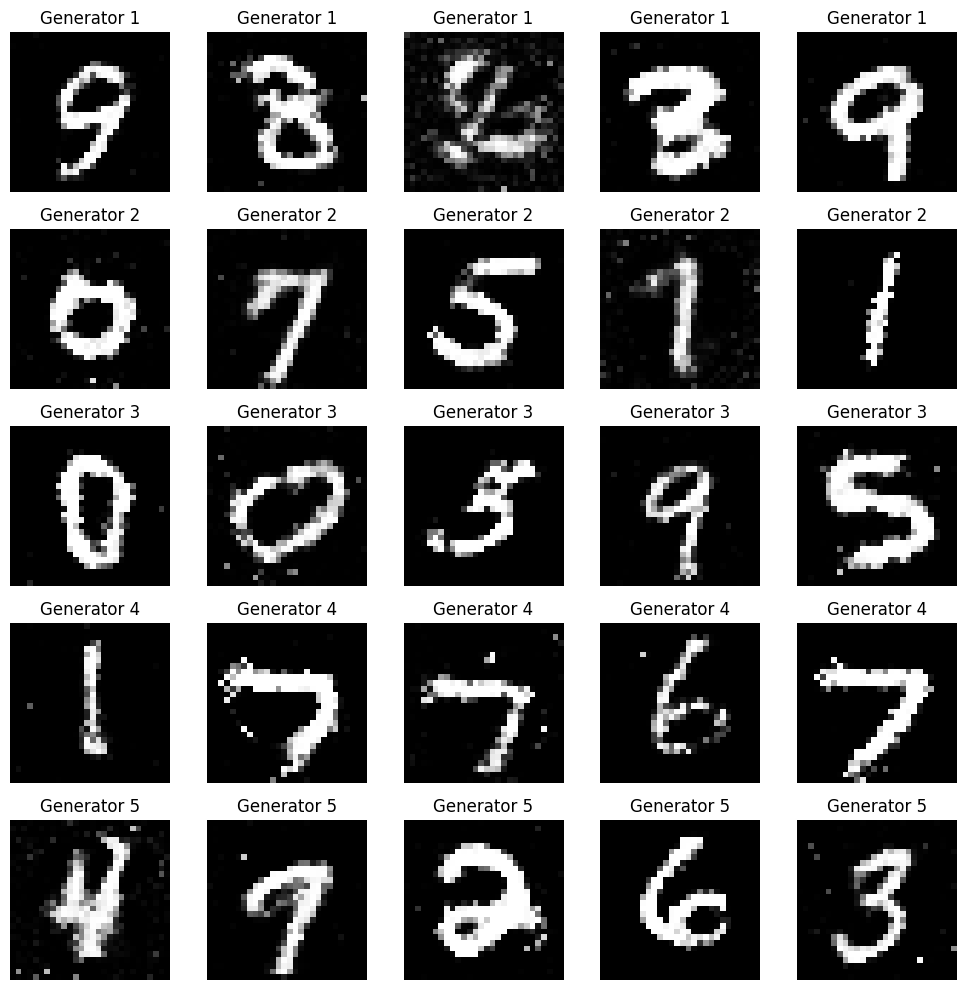

Epoch [41/100], Batch [0/188], D Loss: 1.3013, C Loss: 1.6093, G Loss: -0.7951
Epoch [41/100], Batch [100/188], D Loss: 1.3312, C Loss: 1.6083, G Loss: -0.8483
Epoch [42/100], Batch [0/188], D Loss: 1.3838, C Loss: 1.6101, G Loss: -0.9880
Epoch [42/100], Batch [100/188], D Loss: 1.3539, C Loss: 1.6092, G Loss: -0.8472
Epoch [43/100], Batch [0/188], D Loss: 1.3401, C Loss: 1.6102, G Loss: -0.7652
Epoch [43/100], Batch [100/188], D Loss: 1.3504, C Loss: 1.6101, G Loss: -0.8274
Epoch [44/100], Batch [0/188], D Loss: 1.3613, C Loss: 1.6100, G Loss: -0.8960
Epoch [44/100], Batch [100/188], D Loss: 1.3521, C Loss: 1.6097, G Loss: -0.8910
Epoch [45/100], Batch [0/188], D Loss: 1.3408, C Loss: 1.6085, G Loss: -0.7974
Epoch [45/100], Batch [100/188], D Loss: 1.3450, C Loss: 1.6097, G Loss: -0.8252
Generating samples at epoch 45


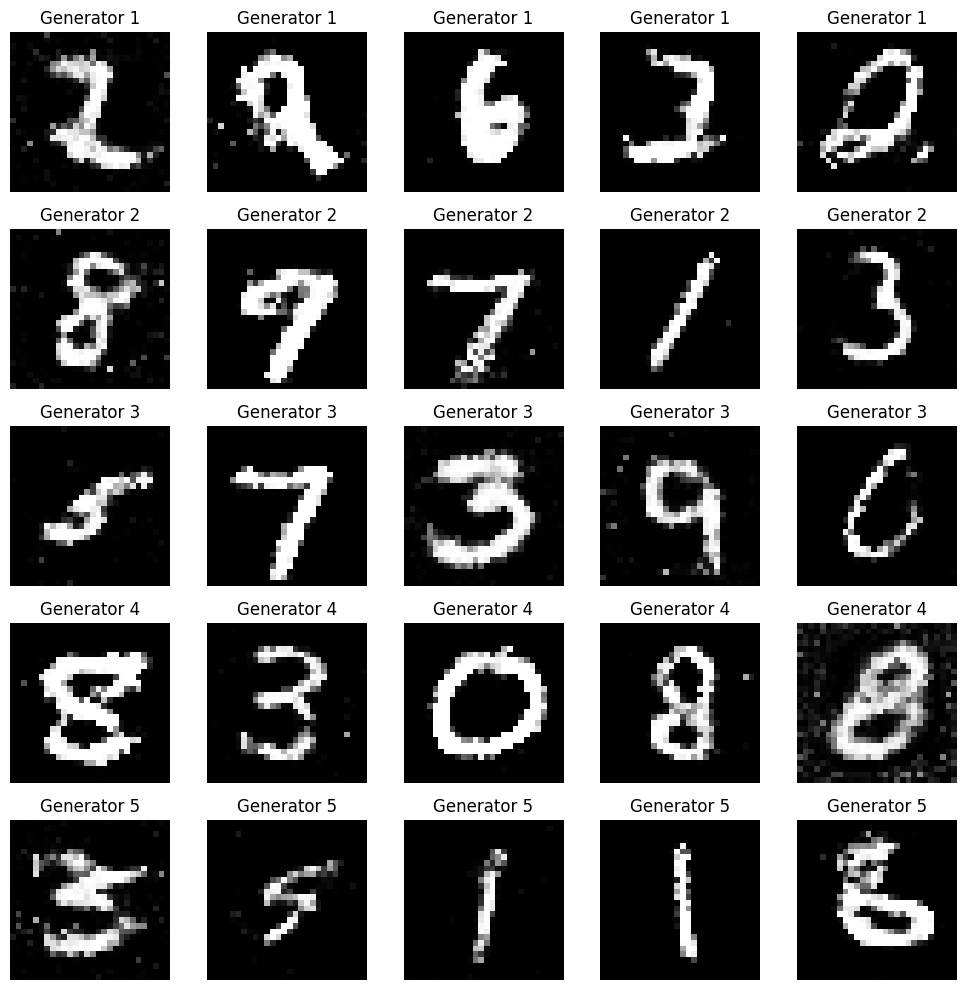

Epoch [46/100], Batch [0/188], D Loss: 1.3267, C Loss: 1.6085, G Loss: -0.6266
Epoch [46/100], Batch [100/188], D Loss: 1.3283, C Loss: 1.6094, G Loss: -0.7190
Epoch [47/100], Batch [0/188], D Loss: 1.3345, C Loss: 1.6097, G Loss: -0.8056
Epoch [47/100], Batch [100/188], D Loss: 1.3777, C Loss: 1.6090, G Loss: -0.9079
Epoch [48/100], Batch [0/188], D Loss: 1.3342, C Loss: 1.6105, G Loss: -0.8176
Epoch [48/100], Batch [100/188], D Loss: 1.3526, C Loss: 1.6093, G Loss: -0.8602
Epoch [49/100], Batch [0/188], D Loss: 1.3799, C Loss: 1.6105, G Loss: -0.9300
Epoch [49/100], Batch [100/188], D Loss: 1.3294, C Loss: 1.6096, G Loss: -0.8202
Epoch [50/100], Batch [0/188], D Loss: 1.3618, C Loss: 1.6096, G Loss: -0.7605
Epoch [50/100], Batch [100/188], D Loss: 1.3904, C Loss: 1.6094, G Loss: -0.7751
Generating samples at epoch 50


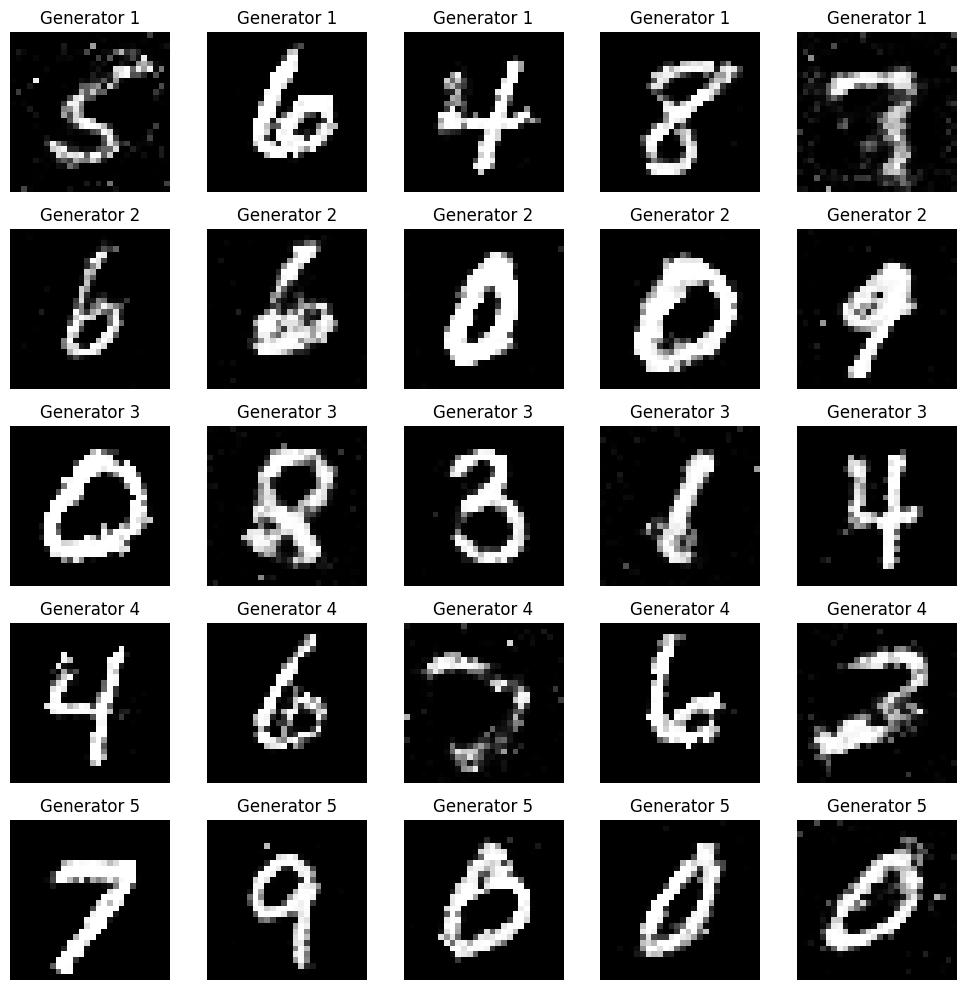

Epoch [51/100], Batch [0/188], D Loss: 1.3728, C Loss: 1.6093, G Loss: -0.7457
Epoch [51/100], Batch [100/188], D Loss: 1.3599, C Loss: 1.6089, G Loss: -0.8266
Epoch [52/100], Batch [0/188], D Loss: 1.3392, C Loss: 1.6094, G Loss: -0.8990
Epoch [52/100], Batch [100/188], D Loss: 1.3489, C Loss: 1.6105, G Loss: -0.9683
Epoch [53/100], Batch [0/188], D Loss: 1.3552, C Loss: 1.6098, G Loss: -0.8909
Epoch [53/100], Batch [100/188], D Loss: 1.3245, C Loss: 1.6102, G Loss: -0.7150
Epoch [54/100], Batch [0/188], D Loss: 1.3678, C Loss: 1.6088, G Loss: -0.8298
Epoch [54/100], Batch [100/188], D Loss: 1.3452, C Loss: 1.6091, G Loss: -0.8213
Epoch [55/100], Batch [0/188], D Loss: 1.4257, C Loss: 1.6092, G Loss: -0.5950
Epoch [55/100], Batch [100/188], D Loss: 1.3422, C Loss: 1.6098, G Loss: -0.8961
Generating samples at epoch 55


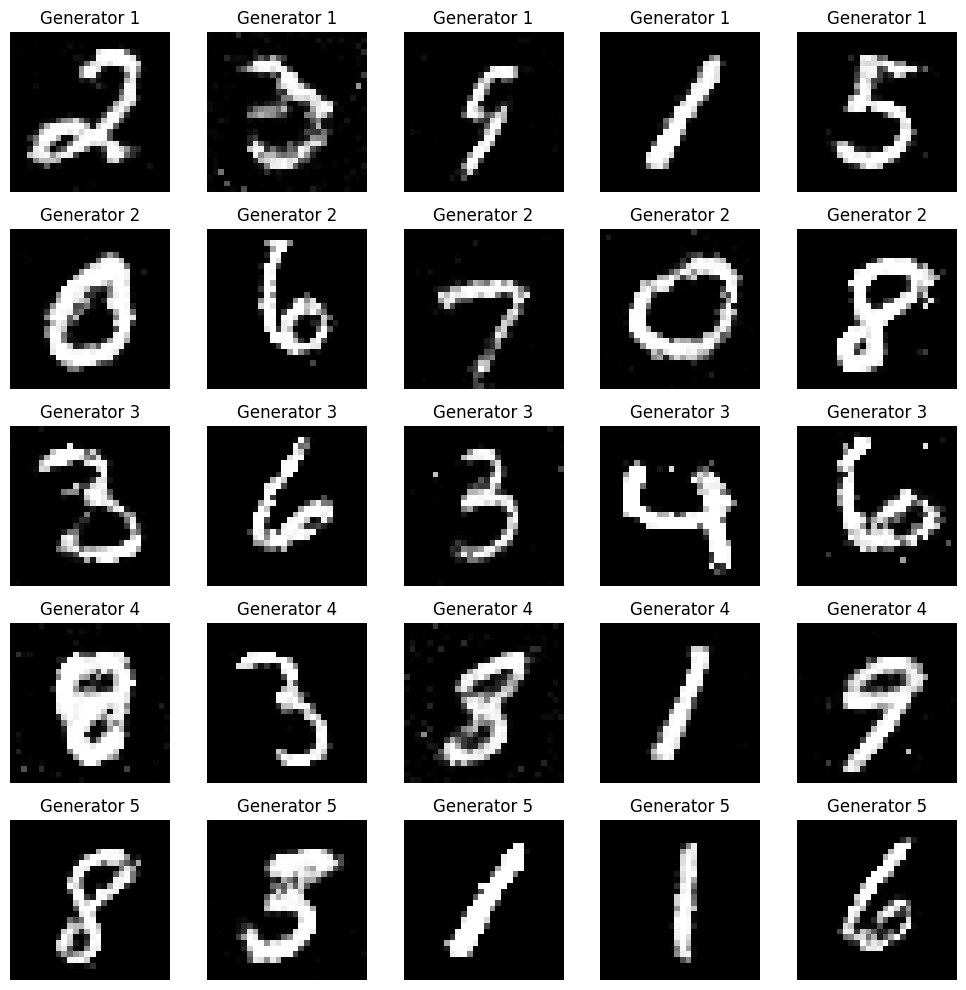

Epoch [56/100], Batch [0/188], D Loss: 1.3617, C Loss: 1.6100, G Loss: -0.7612
Epoch [56/100], Batch [100/188], D Loss: 1.3591, C Loss: 1.6098, G Loss: -0.9444
Epoch [57/100], Batch [0/188], D Loss: 1.3696, C Loss: 1.6095, G Loss: -0.8372
Epoch [57/100], Batch [100/188], D Loss: 1.3663, C Loss: 1.6086, G Loss: -0.8001
Epoch [58/100], Batch [0/188], D Loss: 1.3796, C Loss: 1.6100, G Loss: -0.9509
Epoch [58/100], Batch [100/188], D Loss: 1.3662, C Loss: 1.6100, G Loss: -0.8843
Epoch [59/100], Batch [0/188], D Loss: 1.3460, C Loss: 1.6100, G Loss: -0.8489
Epoch [59/100], Batch [100/188], D Loss: 1.3400, C Loss: 1.6092, G Loss: -0.7438
Epoch [60/100], Batch [0/188], D Loss: 1.3437, C Loss: 1.6105, G Loss: -0.9408
Epoch [60/100], Batch [100/188], D Loss: 1.3568, C Loss: 1.6086, G Loss: -0.9020
Generating samples at epoch 60


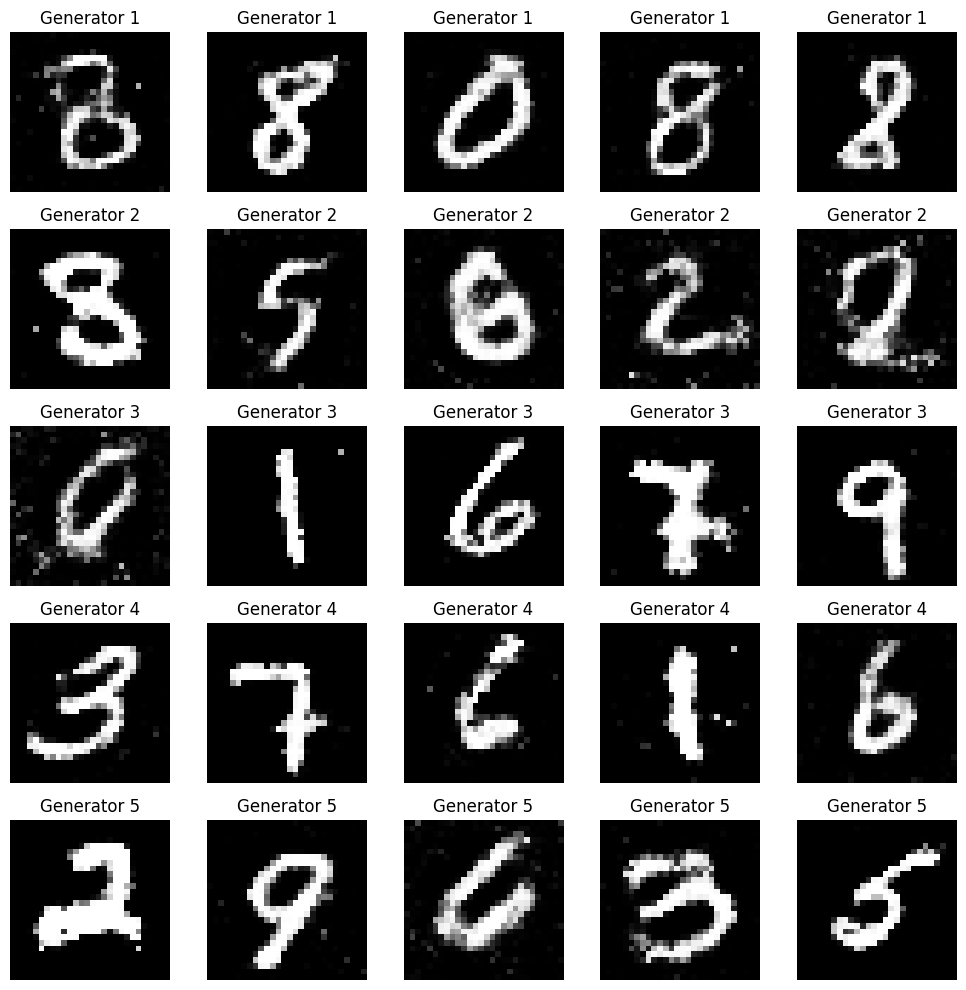

Epoch [61/100], Batch [0/188], D Loss: 1.3585, C Loss: 1.6094, G Loss: -0.9060
Epoch [61/100], Batch [100/188], D Loss: 1.3529, C Loss: 1.6096, G Loss: -0.7397
Epoch [62/100], Batch [0/188], D Loss: 1.3636, C Loss: 1.6092, G Loss: -0.8242
Epoch [62/100], Batch [100/188], D Loss: 1.3602, C Loss: 1.6092, G Loss: -0.8149
Epoch [63/100], Batch [0/188], D Loss: 1.3507, C Loss: 1.6099, G Loss: -0.7969
Epoch [63/100], Batch [100/188], D Loss: 1.3336, C Loss: 1.6098, G Loss: -0.7720
Epoch [64/100], Batch [0/188], D Loss: 1.3602, C Loss: 1.6091, G Loss: -0.9029
Epoch [64/100], Batch [100/188], D Loss: 1.3482, C Loss: 1.6092, G Loss: -0.8620
Epoch [65/100], Batch [0/188], D Loss: 1.3500, C Loss: 1.6090, G Loss: -0.8717
Epoch [65/100], Batch [100/188], D Loss: 1.3672, C Loss: 1.6099, G Loss: -0.8011
Generating samples at epoch 65


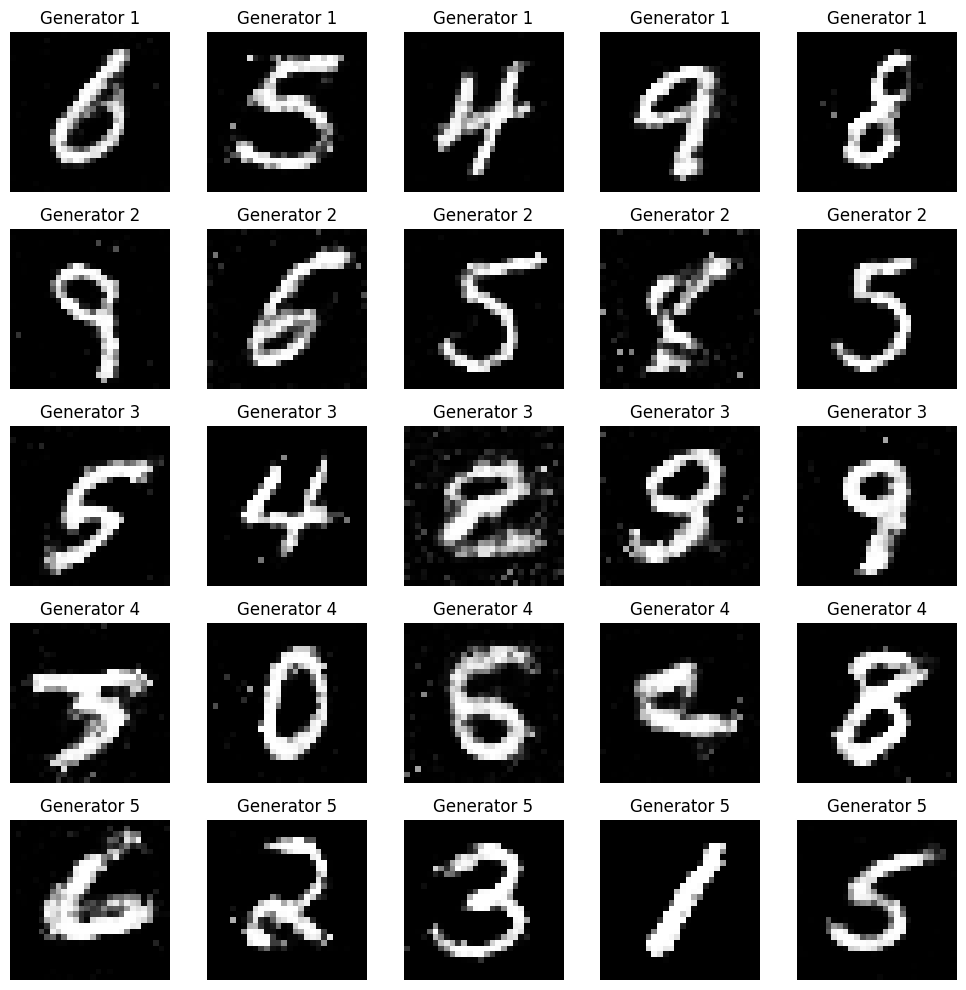

Epoch [66/100], Batch [0/188], D Loss: 1.3593, C Loss: 1.6096, G Loss: -0.7794
Epoch [66/100], Batch [100/188], D Loss: 1.3410, C Loss: 1.6093, G Loss: -0.8154
Epoch [67/100], Batch [0/188], D Loss: 1.3381, C Loss: 1.6094, G Loss: -0.8107
Epoch [67/100], Batch [100/188], D Loss: 1.3480, C Loss: 1.6091, G Loss: -0.7658
Epoch [68/100], Batch [0/188], D Loss: 1.3610, C Loss: 1.6098, G Loss: -0.7909
Epoch [68/100], Batch [100/188], D Loss: 1.3672, C Loss: 1.6086, G Loss: -0.8847
Epoch [69/100], Batch [0/188], D Loss: 1.3554, C Loss: 1.6104, G Loss: -0.8345
Epoch [69/100], Batch [100/188], D Loss: 1.3430, C Loss: 1.6099, G Loss: -0.8607
Epoch [70/100], Batch [0/188], D Loss: 1.3596, C Loss: 1.6096, G Loss: -0.8512
Epoch [70/100], Batch [100/188], D Loss: 1.3424, C Loss: 1.6087, G Loss: -0.8734
Generating samples at epoch 70


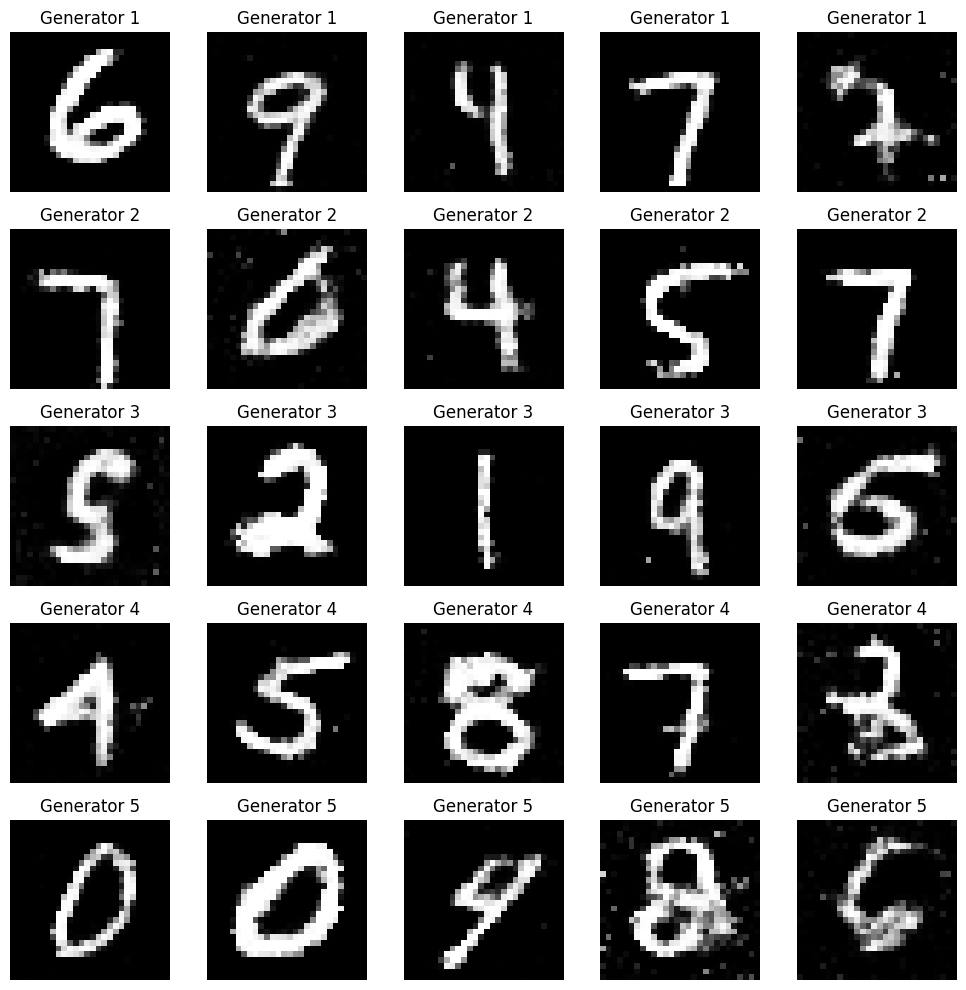

Epoch [71/100], Batch [0/188], D Loss: 1.3603, C Loss: 1.6099, G Loss: -0.8324
Epoch [71/100], Batch [100/188], D Loss: 1.3660, C Loss: 1.6090, G Loss: -0.8425
Epoch [72/100], Batch [0/188], D Loss: 1.3498, C Loss: 1.6091, G Loss: -0.8881
Epoch [72/100], Batch [100/188], D Loss: 1.3661, C Loss: 1.6092, G Loss: -0.7627
Epoch [73/100], Batch [0/188], D Loss: 1.3551, C Loss: 1.6094, G Loss: -0.8492
Epoch [73/100], Batch [100/188], D Loss: 1.3494, C Loss: 1.6096, G Loss: -0.8195
Epoch [74/100], Batch [0/188], D Loss: 1.3646, C Loss: 1.6101, G Loss: -0.8458
Epoch [74/100], Batch [100/188], D Loss: 1.3372, C Loss: 1.6098, G Loss: -0.8329
Epoch [75/100], Batch [0/188], D Loss: 1.3517, C Loss: 1.6098, G Loss: -0.7755
Epoch [75/100], Batch [100/188], D Loss: 1.3515, C Loss: 1.6095, G Loss: -0.8867
Generating samples at epoch 75


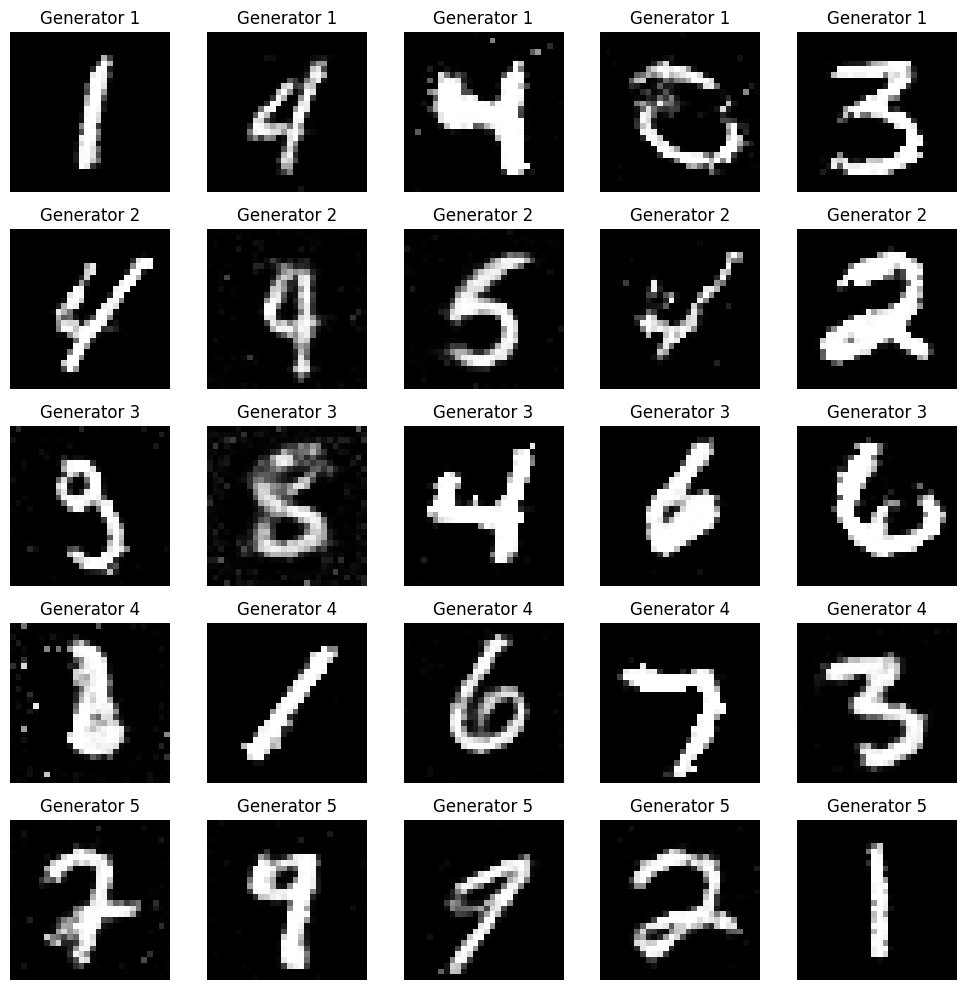

Epoch [76/100], Batch [0/188], D Loss: 1.3458, C Loss: 1.6092, G Loss: -0.9007
Epoch [76/100], Batch [100/188], D Loss: 1.3510, C Loss: 1.6094, G Loss: -0.9109
Epoch [77/100], Batch [0/188], D Loss: 1.3539, C Loss: 1.6099, G Loss: -0.8305
Epoch [77/100], Batch [100/188], D Loss: 1.3655, C Loss: 1.6094, G Loss: -0.8914
Epoch [78/100], Batch [0/188], D Loss: 1.3508, C Loss: 1.6096, G Loss: -0.8383
Epoch [78/100], Batch [100/188], D Loss: 1.3357, C Loss: 1.6099, G Loss: -0.7462
Epoch [79/100], Batch [0/188], D Loss: 1.3474, C Loss: 1.6093, G Loss: -0.8627
Epoch [79/100], Batch [100/188], D Loss: 1.3542, C Loss: 1.6093, G Loss: -0.8928
Epoch [80/100], Batch [0/188], D Loss: 1.3648, C Loss: 1.6095, G Loss: -0.7861
Epoch [80/100], Batch [100/188], D Loss: 1.3973, C Loss: 1.6093, G Loss: -0.7697
Generating samples at epoch 80


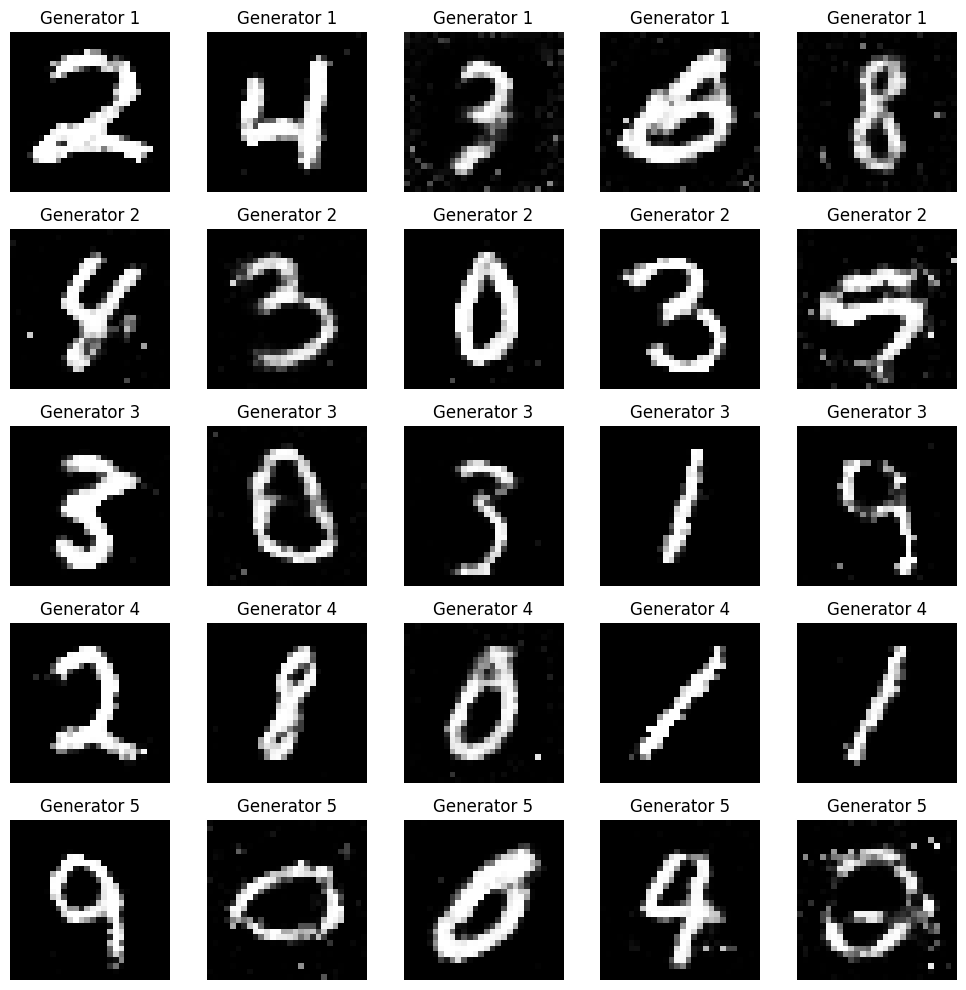

Epoch [81/100], Batch [0/188], D Loss: 1.3539, C Loss: 1.6093, G Loss: -0.8228
Epoch [81/100], Batch [100/188], D Loss: 1.3634, C Loss: 1.6103, G Loss: -0.9799
Epoch [82/100], Batch [0/188], D Loss: 1.3597, C Loss: 1.6101, G Loss: -0.8612
Epoch [82/100], Batch [100/188], D Loss: 1.3541, C Loss: 1.6104, G Loss: -0.7964
Epoch [83/100], Batch [0/188], D Loss: 1.3884, C Loss: 1.6090, G Loss: -0.7927
Epoch [83/100], Batch [100/188], D Loss: 1.3522, C Loss: 1.6108, G Loss: -0.9052
Epoch [84/100], Batch [0/188], D Loss: 1.3573, C Loss: 1.6097, G Loss: -0.8466
Epoch [84/100], Batch [100/188], D Loss: 1.3645, C Loss: 1.6085, G Loss: -0.7880
Epoch [85/100], Batch [0/188], D Loss: 1.3668, C Loss: 1.6095, G Loss: -0.8116
Epoch [85/100], Batch [100/188], D Loss: 1.3459, C Loss: 1.6091, G Loss: -0.9023
Generating samples at epoch 85


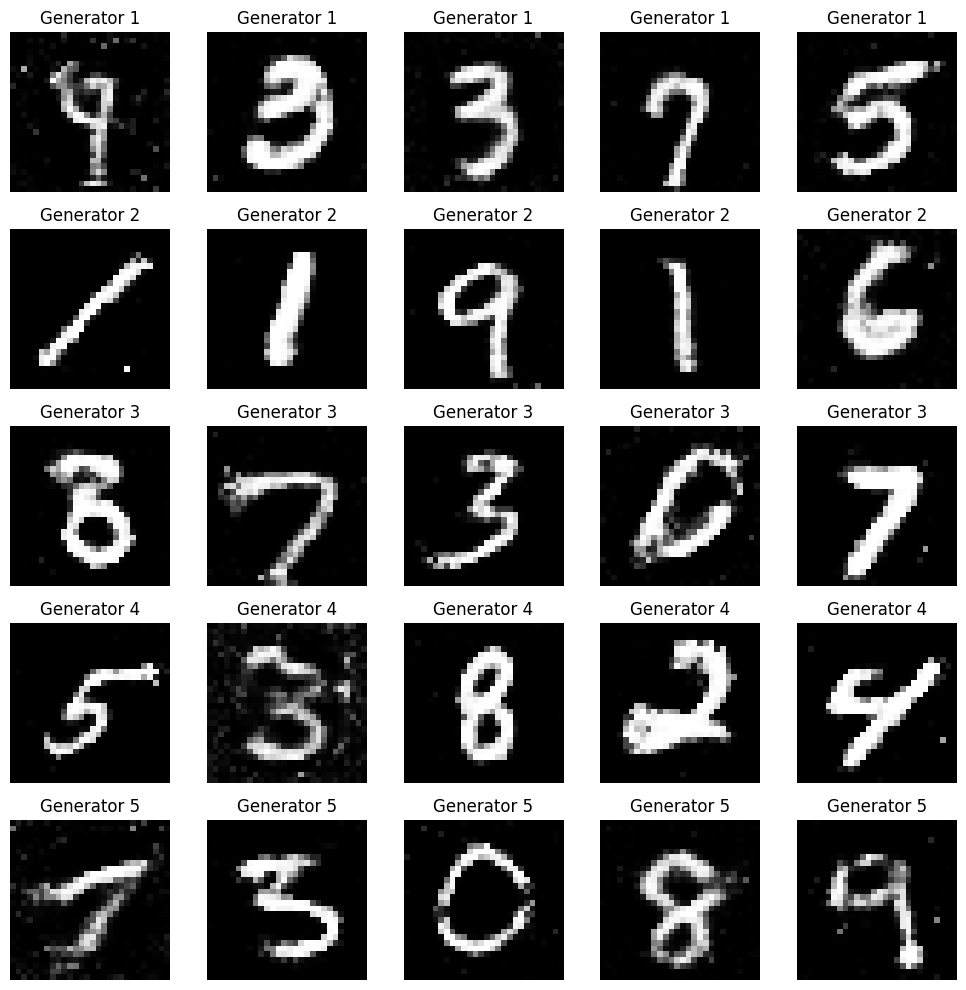

Epoch [86/100], Batch [0/188], D Loss: 1.3621, C Loss: 1.6103, G Loss: -0.8223
Epoch [86/100], Batch [100/188], D Loss: 1.3199, C Loss: 1.6098, G Loss: -0.7933
Epoch [87/100], Batch [0/188], D Loss: 1.3546, C Loss: 1.6092, G Loss: -0.8726
Epoch [87/100], Batch [100/188], D Loss: 1.3509, C Loss: 1.6098, G Loss: -0.8649
Epoch [88/100], Batch [0/188], D Loss: 1.3493, C Loss: 1.6090, G Loss: -0.8153
Epoch [88/100], Batch [100/188], D Loss: 1.3498, C Loss: 1.6092, G Loss: -0.8447
Epoch [89/100], Batch [0/188], D Loss: 1.3609, C Loss: 1.6099, G Loss: -0.7024
Epoch [89/100], Batch [100/188], D Loss: 1.3406, C Loss: 1.6096, G Loss: -0.8418
Epoch [90/100], Batch [0/188], D Loss: 1.3596, C Loss: 1.6104, G Loss: -0.8403
Epoch [90/100], Batch [100/188], D Loss: 1.3681, C Loss: 1.6095, G Loss: -0.8248
Generating samples at epoch 90


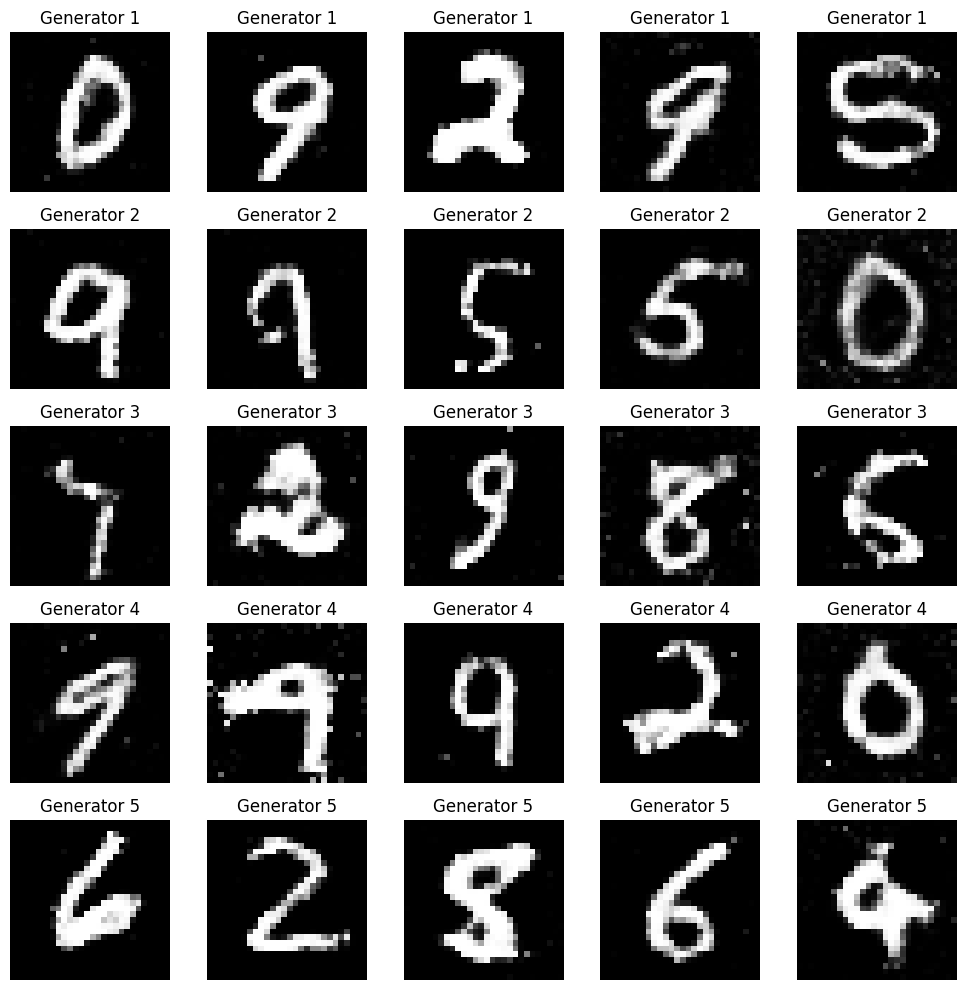

Epoch [91/100], Batch [0/188], D Loss: 1.3343, C Loss: 1.6107, G Loss: -0.9470
Epoch [91/100], Batch [100/188], D Loss: 1.3808, C Loss: 1.6105, G Loss: -0.8502
Epoch [92/100], Batch [0/188], D Loss: 1.3434, C Loss: 1.6097, G Loss: -0.7766
Epoch [92/100], Batch [100/188], D Loss: 1.3507, C Loss: 1.6094, G Loss: -0.8603
Epoch [93/100], Batch [0/188], D Loss: 1.3521, C Loss: 1.6106, G Loss: -0.8922
Epoch [93/100], Batch [100/188], D Loss: 1.3634, C Loss: 1.6098, G Loss: -0.8998
Epoch [94/100], Batch [0/188], D Loss: 1.3415, C Loss: 1.6092, G Loss: -0.9126
Epoch [94/100], Batch [100/188], D Loss: 1.3391, C Loss: 1.6100, G Loss: -0.8510
Epoch [95/100], Batch [0/188], D Loss: 1.3776, C Loss: 1.6097, G Loss: -0.9700
Epoch [95/100], Batch [100/188], D Loss: 1.3668, C Loss: 1.6092, G Loss: -0.7109
Generating samples at epoch 95


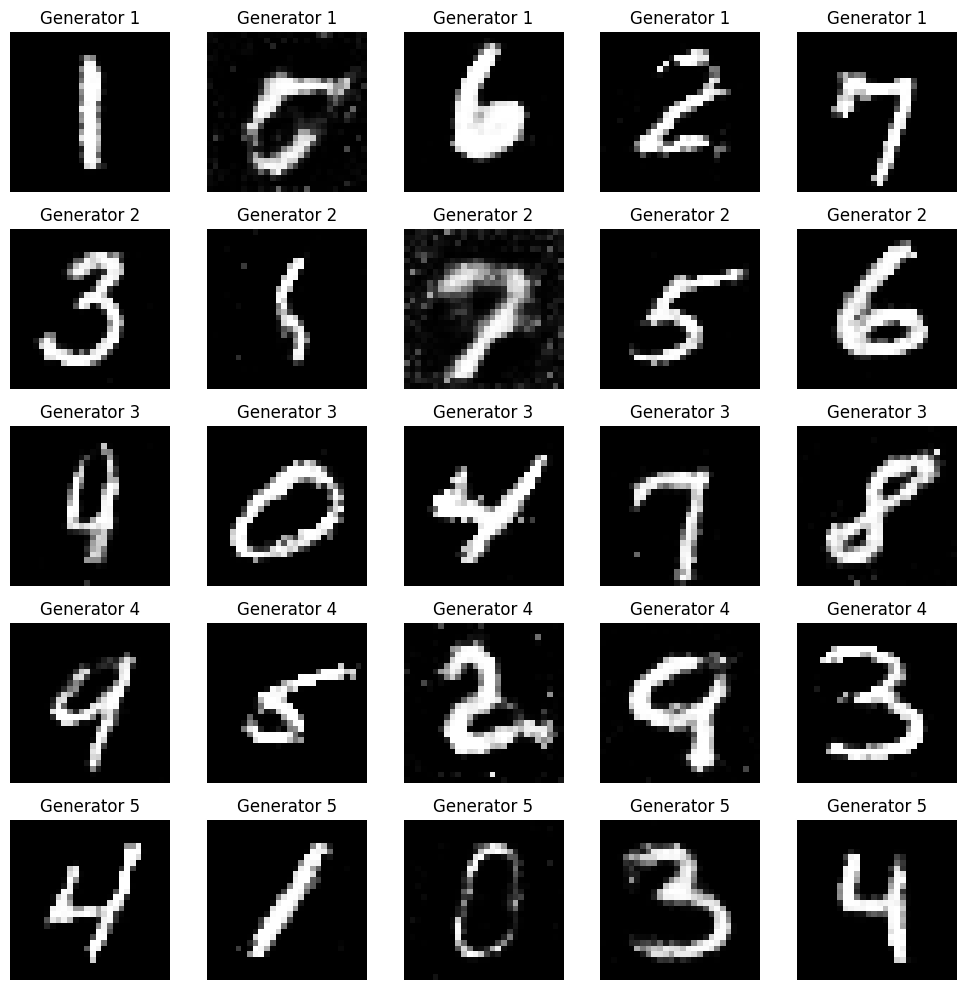

Epoch [96/100], Batch [0/188], D Loss: 1.3652, C Loss: 1.6104, G Loss: -0.7312
Epoch [96/100], Batch [100/188], D Loss: 1.3539, C Loss: 1.6099, G Loss: -0.8559
Epoch [97/100], Batch [0/188], D Loss: 1.3868, C Loss: 1.6098, G Loss: -0.9155
Epoch [97/100], Batch [100/188], D Loss: 1.3630, C Loss: 1.6103, G Loss: -0.9005
Epoch [98/100], Batch [0/188], D Loss: 1.3528, C Loss: 1.6096, G Loss: -0.8459
Epoch [98/100], Batch [100/188], D Loss: 1.3634, C Loss: 1.6098, G Loss: -0.9210
Epoch [99/100], Batch [0/188], D Loss: 1.3742, C Loss: 1.6096, G Loss: -0.9065
Epoch [99/100], Batch [100/188], D Loss: 1.3447, C Loss: 1.6095, G Loss: -0.8682
Epoch [100/100], Batch [0/188], D Loss: 1.3733, C Loss: 1.6108, G Loss: -0.9457
Epoch [100/100], Batch [100/188], D Loss: 1.3531, C Loss: 1.6092, G Loss: -0.7032
Generating samples at epoch 100


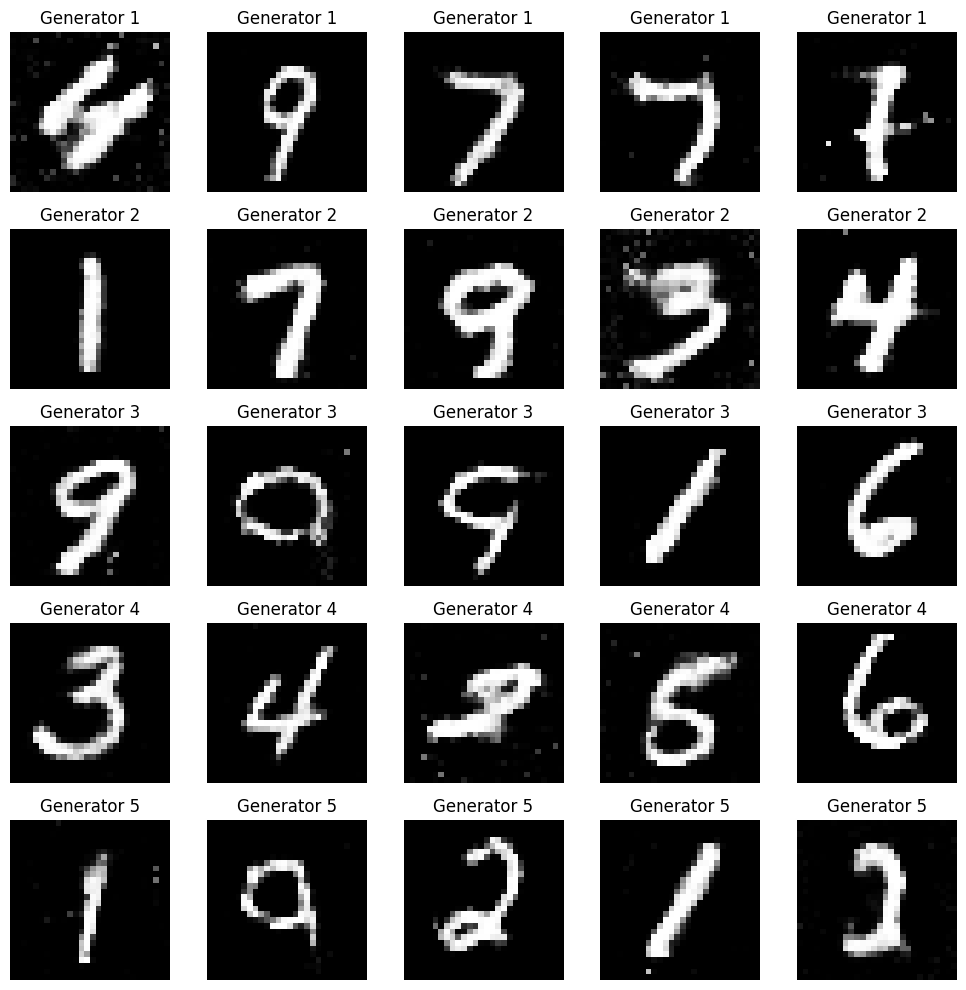

In [12]:


# Initialize models
shared_generator_layers = SharedGeneratorLayers().to(device)
shared_disc_class_layers = SharedDiscriminatorClassifierLayers().to(device)

generators = [Generator(latent_dim, shared_generator_layers).to(device) for _ in range(num_generators)]
discriminator = Discriminator(shared_disc_class_layers).to(device)
classifier = Classifier(shared_disc_class_layers, num_generators).to(device)

# Train the model
history = train_mgans(generators, discriminator, classifier, train_loader, latent_dim, num_epochs, beta, device, visualize_frequency)


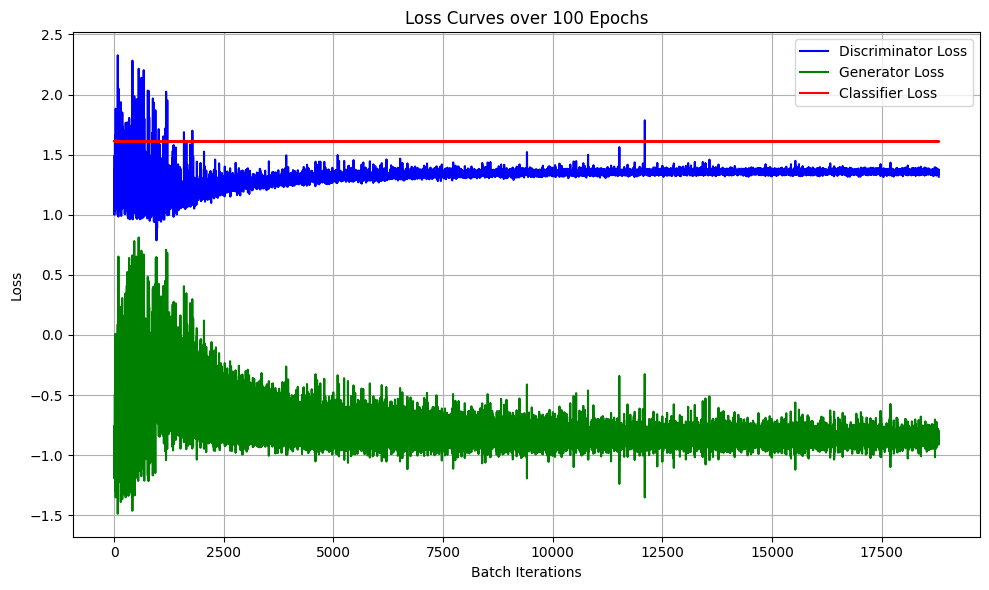

In [13]:
plot_training_history(history, num_epochs)